In [1]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

import numpy as np
from random import random, uniform, randrange, triangular
from tqdm import tqdm

In [2]:
#Pytorch imports
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [295]:
import os
files = os.listdir("dataset")

import csv

class Route:
    def __init__(self, phi, v, M, IMU_v, IMU_alpha):
        self.phi = phi
        self.v = v
        self.M = M
        self.IMU_v = IMU_v
        self.IMU_alpha = IMU_alpha
    def __len__(self):
        return len(self.phi)
    
routes = []

allRows = 0

maxAngle = 0
maxSpeed = 0
maxTorque = 0

maxVDot = [0]*3
maxAlphaDot = [0]*3
for file in files:
    path = os.path.join("dataset", file)
    with open(path, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=' ')
        phi = []
        v = []
        M = []
        IMU_v = []
        IMU_alpha = []
        
        maxAngle2 = 0
        maxSpeed2 = 0
        maxTorque2 = 0

        maxVDot2 = [0]*3
        maxAlphaDot2 = [0]*3
        for row in spamreader:
            phi.append(float(row[1]))
            v.append(float(row[2]))
            M.append(float(row[3]))
            
            vPacket = [float(row[i]) for i in range(4, 7)]
            alphaPacket = [float(row[i]) for i in range(7, 10)]
            IMU_v.append(vPacket)
            IMU_alpha.append(alphaPacket)
            
            maxAngle2 = max(abs(float(row[1])), maxAngle2)
            maxSpeed2 = max(abs(float(row[2])), maxSpeed2)
            maxTorque2 = max(abs(float(row[3])), maxTorque2)
            
            for i in range(3):
                maxVDot2[i] = max(abs(float(row[4+i])), maxVDot2[i])
                maxAlphaDot2[i] = max(abs(float(row[7+i])), maxAlphaDot2[i])
        if min(v) > 25 and max(v)<34:
            routes.append(Route(torch.tensor(phi), torch.tensor(v), torch.tensor(M), torch.tensor(IMU_v).permute(1,0), torch.tensor(IMU_alpha).permute(1,0)))
            allRows += len(phi)
            maxAngle = max(maxAngle, maxAngle2)
            maxSpeed = max(maxSpeed, maxSpeed2)
            maxTorque = max(maxTorque, maxTorque2)
            for i in range(3):
                maxVDot[i] = max(maxVDot[i], maxVDot2[i])
                maxAlphaDot[i] = max(maxAlphaDot[i], maxAlphaDot2[i])


print(allRows)
print(maxAngle, maxSpeed, maxTorque, maxVDot, maxAlphaDot)

324646
18.600000381469727 33.88642883300781 1.0 [18.733535766601562, 8.428146362304688, 9.84222412109375] [0.103515625, 0.3721466064453125, 0.1421051025390625]


In [296]:
class SimDataset(Dataset):
    def __init__(self, length, i, o):
        self.len = length
        self.i = i
        self.o = o

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.i[idx], self.o[idx]

prev_data = 100
fwd_data = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


all_routes = len(routes)
print(f"{all_routes} routes")
test_count = int(all_routes*0.2)
test_routes_id = [randrange(all_routes) for _ in range(test_count)]
test_routes_id = [47, 9, 9, 21, 29, 57, 31, 36, 55, 17, 32, 3]

train_routes = [routes[i] for i in range(all_routes) if i not in test_routes_id]
test_routes = [routes[i] for i in range(all_routes) if i in test_routes_id]
#Phi, v, M, IMU_v, IMU_alpha
groups = [2, 10, 25, 10, 10]

input_length = prev_data//groups[0] + prev_data//groups[1] + (prev_data+fwd_data[-1])//groups[2] + 3*prev_data//groups[3] + 3*prev_data//groups[4]
output_length = len(fwd_data)

def caddy_dataset(train):
    i_data = []
    o_data = []
    routes = train_routes if train else test_routes
    for route in tqdm(routes):
        for idx in range(prev_data, len(route.v)-fwd_data[-1], 5):
            phi = route.phi[idx-prev_data : idx]/maxAngle
            v = route.v[idx-prev_data : idx]/maxSpeed
            M = route.M[idx-prev_data : idx+fwd_data[-1]]/maxTorque
            
            phi = phi.reshape(-1, groups[0]).mean(axis=1)
            v = v.reshape(-1, groups[1]).mean(axis=1)
            M = M.reshape(-1, groups[2]).mean(axis=1)
            
            IMU_v = [(route.IMU_v[i][idx-prev_data:idx]/maxVDot[i]).reshape(-1, groups[3]).mean(axis=1) for i in range(3)]
            IMU_alpha = [(route.IMU_alpha[i][idx-prev_data:idx]/maxAlphaDot[i]).reshape(-1, groups[4]).mean(axis=1) for i in range(3)]
            
            o = torch.zeros((output_length,))
            for i in range(output_length):
                o[i] = route.phi[idx+fwd_data[i]]/maxAngle
            data = (phi, v, M, IMU_v[0], IMU_v[1], IMU_v[2], IMU_alpha[0], IMU_alpha[1], IMU_alpha[2])
            data_input = np.concatenate(data)
            i_data.append(data_input)
            o_data.append(o)
    return SimDataset(len(i_data), i_data, o_data)


train_set = caddy_dataset(True)
test_set = caddy_dataset(False)

print(len(train_set), len(test_set), test_routes_id)

  0%|          | 0/27 [00:00<?, ?it/s]

34 routes


100%|██████████| 7/7 [00:04<00:00,  1.57it/s]

51484 12100 [47, 9, 9, 21, 29, 57, 31, 36, 55, 17, 32, 3]


In [297]:
train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=False)
print(len(train_dataloader))
print(len(test_dataloader))

804
190


In [298]:
# base_size = prev_data//group_base
# IMU_size = prev_data//group_IMU
# torque_size = (prev_data + fwd_data)//group_base
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_length, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_length),
            nn.Tanh()
        )

        
    def forward(self, x):
        return self.linear_relu_stack(x)
print(input_length)

128


In [299]:
def train_loop(dataloader, model, loss_fn, optimizer, debug):
    size = len(dataloader.dataset)
    for X, y in dataloader:
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss = loss.item()*maxAngle*maxAngle
    if debug:
        print(f"Train loss: {loss}")
    return loss

def test_loop(dataloader, model, loss_fn, debug):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()*maxAngle*maxAngle

    test_loss /= num_batches
    if debug:
        print(f"Test  loss: {test_loss} \n")
    return test_loss

model = NeuralNetwork()
for p in model.parameters():
    print(p.shape)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

torch.Size([64, 128])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])
17226


Epoch 0
Train loss: 9.722654603547387
Test  loss: 6.621498173793115 

Epoch 5
Train loss: 0.5929503773714593
Test  loss: 0.5223186161262008 

Epoch 10
Train loss: 0.35678906427143525
Test  loss: 0.2707834260906858 

Epoch 15
Train loss: 0.8605219575017473
Test  loss: 0.22024284068352615 

Epoch 20
Train loss: 0.2937623219733841
Test  loss: 0.19763467598018625 

Epoch 25
Train loss: 0.28840713029244724
Test  loss: 0.18652756055129546 

Epoch 30
Train loss: 0.3157114771682616
Test  loss: 0.17520563644018852 

Epoch 35
Train loss: 0.622292399944393
Test  loss: 0.1687796646536783 

Epoch 40
Train loss: 0.5087306640120497
Test  loss: 0.16235795662999883 

Epoch 45
Train loss: 0.2432493185144216
Test  loss: 0.15973294879199593 

Epoch 50
Train loss: 0.25722463878704904
Test  loss: 0.15625143690639556 

Epoch 55
Train loss: 0.5517152946993726
Test  loss: 0.15517405354798597 

Epoch 60
Train loss: 0.19991657046361583
Test  loss: 0.15214121474769368 

Epoch 65
Train loss: 0.39196315521210146
Te

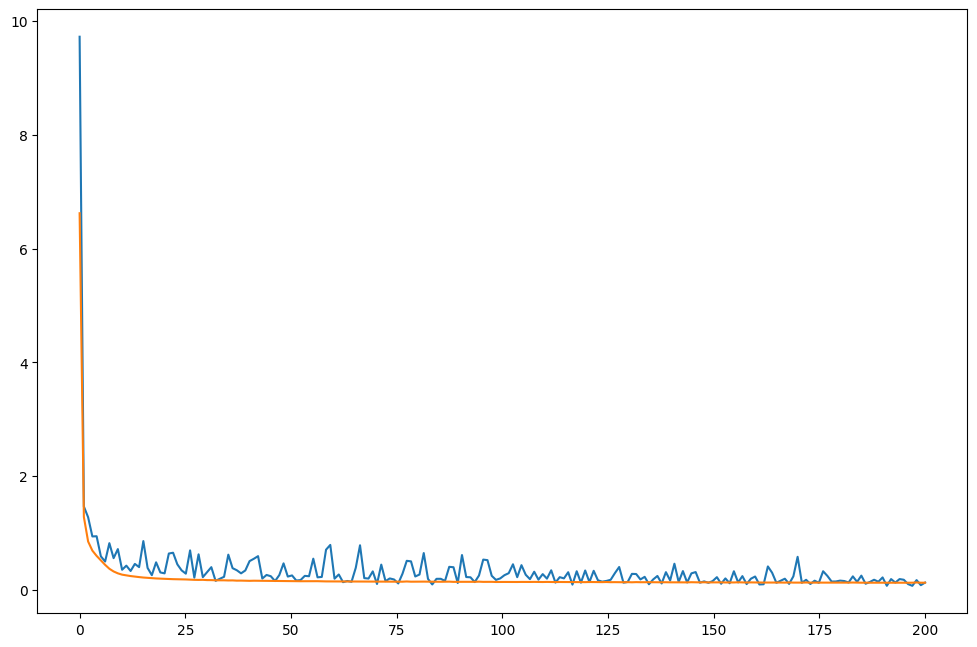

In [300]:
epochs = 200
skip = 5
loss_t = []
loss_e = []
for t in range(epochs):
    if t%skip == 0:
        print(f"Epoch {t}")
    loss_t.append(train_loop(train_dataloader, model, loss_fn, optimizer, t%skip==0))
    loss_e.append(test_loop(test_dataloader, model, loss_fn, t%skip==0))

plt.plot(np.linspace(0, epochs, epochs), loss_t)
plt.plot(np.linspace(0, epochs, epochs), loss_e)

-1.3499999874541828 initial angle
tensor([-1.3500, -1.3500, -1.3500, -1.5000, -1.5000, -1.5000, -1.5000, -1.5000,
        -1.3500, -1.3500])
tensor([-1.4768, -1.5302, -1.5420, -1.5769, -1.5526, -1.6010, -1.5232, -1.4758,
        -1.4516, -1.4706], grad_fn=<MulBackward0>)


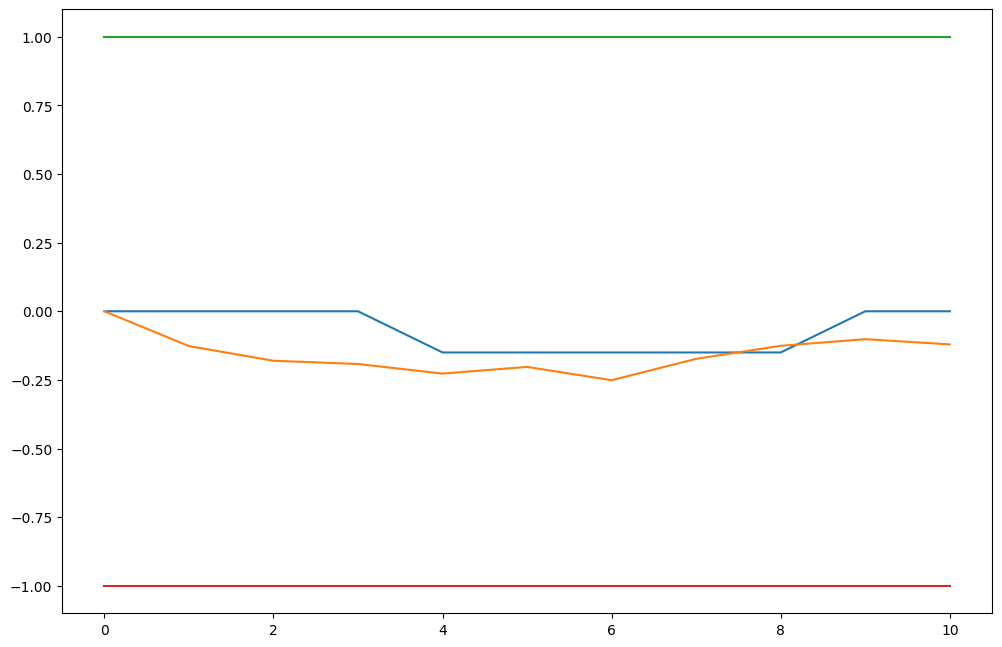

In [328]:
random_sample = test_set[randrange(len(test_set))]
initial_angle = random_sample[0][prev_data//groups[0]-1]*maxAngle
print(initial_angle, "initial angle")
print(random_sample[1]*maxAngle)

torch_data_input = torch.from_numpy(random_sample[0])
torch_data_output = model(torch_data_input)
print(torch_data_output*maxAngle)

ls_good = [0] +[random_sample[1][i]*maxAngle - initial_angle for i in range(output_length)]
ls_pred = [0] +[torch_data_output[i]*maxAngle - initial_angle for i in range(output_length)]

plt.plot(np.linspace(0, output_length, output_length+1), ls_good)
plt.plot(np.linspace(0, output_length, output_length+1), ls_pred)
plt.plot(np.linspace(0, output_length, output_length+1), np.ones((output_length+1,))*1)
plt.plot(np.linspace(0, output_length, output_length+1), np.ones((output_length+1,))*-1)

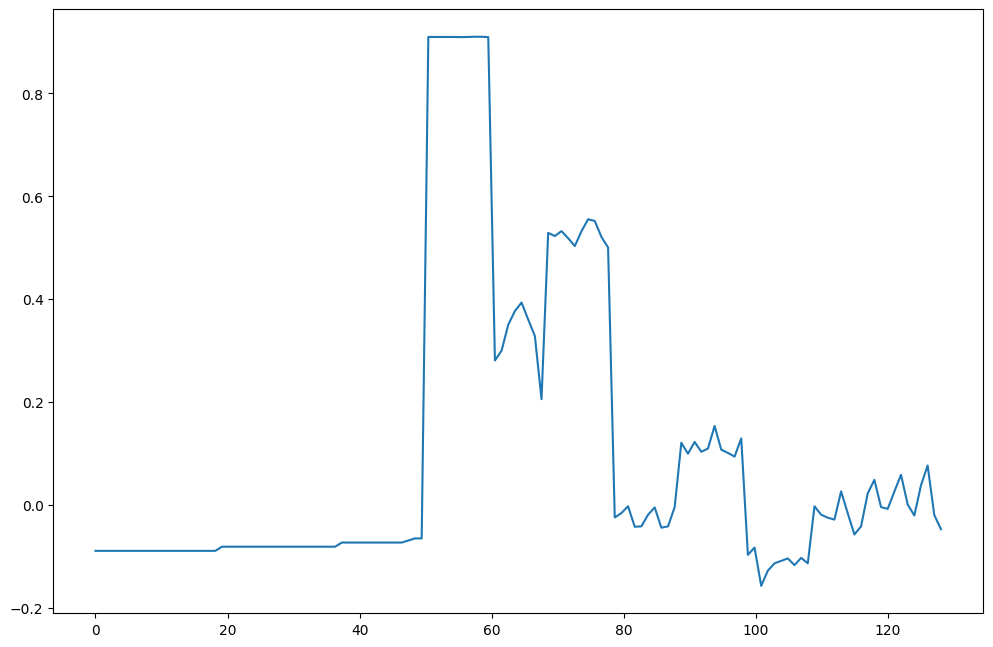

In [307]:
random_sample = test_set[randrange(len(test_set))]
data_input = random_sample[0]
ln = len(data_input)
plt.plot(np.linspace(0, ln, ln), data_input)

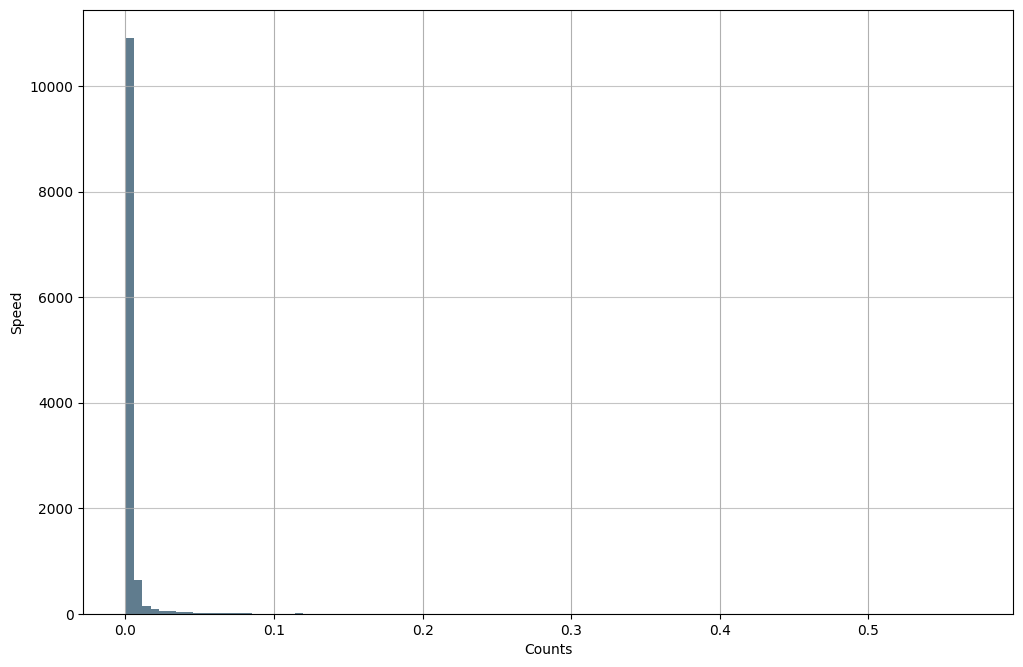

In [305]:
import pandas as pd
lshape = []
for random_sample in test_set:

    data_input = random_sample[0]
    torch_data_input = torch.from_numpy(data_input)
    torch_data_output = model(torch_data_input)

    ls_good = [random_sample[1][i]*maxTorque for i in range(output_length)]
    ls_pred = [torch_data_output[i]*maxTorque for i in range(output_length)]
    mse = sum([(ls_good[i].item()-ls_pred[i].item())**2 for i in range(output_length)])
    lshape.append(mse)
size, scale = 1000, 20
commutes = pd.Series(np.array(lshape))

commutes.plot.hist(grid=True, bins=100, color='#607c8e')
plt.xlabel('Counts')
plt.ylabel('Speed')
plt.grid(axis='y', alpha=0.75)

In [329]:
torch.save(model, 'model_s2.pth')